In [1]:
import datetime
current_datetime = datetime.datetime.today()
print("This .ipynb last executed at {0}".format(current_datetime))

This .ipynb last executed at 2020-11-15 18:54:43.266451


# Prediction by ML model and Localization

## Steps
1. Use the trained model to predict the region by the ML model and RSSI fingerprint
2. Remove the RSSI that measured by the bad base stations.
        Bad BS = the RSSI value between that BS and the target is smaller than the expected RSSI
3. Perform LLS again to check the performance of this algorithm.

## Import Libraries
Import all necessary python libraries.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) #Setting to display All columns of Dataframe
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report

import keras as keras
from keras.utils import np_utils

### Self libraries ###
from mymodule import myLLS_v2 as myLLS
from mymodule.submodule import CoordinateSystem_v2 as myCoordinateSystem
from mymodule import RadioPropagation_v2 as myRadioPropagation


## Function - Load Testing Data and ML Model

In [3]:
def readData(normalized_train_filepath=None,normalized_test_filepath=None,original_filepath=None):
    print("Importing......")
    #Import train data for reference
    df_normalized_train = pd.read_excel(normalized_train_filepath, index_col=0)
    print(normalized_train_filepath)
    
    #Import test data to make DNN to predict
    df_normalized_test = pd.read_excel(normalized_test_filepath, index_col=0)
    print(normalized_test_filepath)
    
    #Import cleaned data to reperform localization
    df = pd.read_excel(original_filepath, index_col=0)
    ##Extract train data rows
    device_list = df_normalized_train['device'].tolist()
    seqNumber_list = df_normalized_train['seqNumber'].tolist()
    df_train = df[df['device'].isin(device_list) & df['seqNumber'].isin(seqNumber_list)]
    ##Extract test data rows
    device_list = df_normalized_test['device'].tolist()
    seqNumber_list = df_normalized_test['seqNumber'].tolist()
    df_test = df[df['device'].isin(device_list) & df['seqNumber'].isin(seqNumber_list)]
    print(original_filepath)
    return df_normalized_test, df_test, df_normalized_train, df_train

#Prepare data for prediction
def prepareMLData(dataframe=None):
    drop_col_name = ['device','seqNumber','location','LocationEncoded','gps','file',
                     'PathLossExponent','ReferenceRSSI','DeviceLLSLat','DeviceLLSLng','LocalizationError',
                     'nCrPathLossExponent','nCrReferenceRSSI','nCrDeviceLLSLat','nCrDeviceLLSLng','nCrLocalizationError'
                    ]
    x_test = dataframe.drop(drop_col_name,axis=1)
    y_test = dataframe['LocationEncoded']

    #Before continuing, we need to convert all feature data (x_test) and 
    #label data (y_test) into a datatype accepted by Keras.
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    #Conduct one-hot-encoding of our labels. Please only execute this line once!
    num_classes = len(y_test.unique().tolist())
    y_test_hot = np_utils.to_categorical(y_test, num_classes)
    return x_test,y_test,y_test_hot


In [4]:
#Get rssi data
normalized_train_filepath = '5.1_normalized_train_data.xlsx'
normalized_test_filepath = '5.1_normalized_test_data.xlsx'
original_filepath = '5.1_data_allinone.xlsx'
df_normalized_data, df_data, df_normalized_train, df_train = readData(normalized_train_filepath,
                                                                      normalized_test_filepath,
                                                                      original_filepath)

#Prepare data for prediction
x_test, y_test, y_test_hot = prepareMLData(df_normalized_data)


Importing......
5.1_normalized_train_data.xlsx
5.1_normalized_test_data.xlsx
5.1_data_allinone.xlsx


## Load DNN model

In [5]:
def getDNN(filepath=None):
    #Import the trained DNN model
    print("\n=== Import DNN model <BEGIN> ===================")
    model = keras.models.load_model(filepath)
    print(model.summary())
    print("=== Import DNN model <END> ===================\n")
    return model

def getCNN(filepath=None):
    #Import the trained DNN model
    print("\n=== Import DNN model <BEGIN> ===================")
    model = keras.models.load_model(filepath)
    print(model.summary())
    print("=== Import DNN model <END> ===================\n")
    return model


In [6]:
#Get DNN model
dnn_filepath = r'models/rssi_dnn_5layer_100node_v3.h5'
model = getDNN(dnn_filepath)


=== Import DNN model <BEGIN> ===================
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               7200      
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 404       
Total params: 48,004
Trainable params: 48,004
Non-trainable params: 0


## Set some standard parameters
same labels will be reused throughout the program

In [7]:

#Set some standard parameters, Same labels will be reused throughout the program
LABELS = df_normalized_data['location'].unique().tolist()
LABELS_GPS = df_normalized_data['gps'].unique().tolist()
# bs_list = df_data['station'].sort_values().unique()
device_list = df_normalized_data['device'].tolist()
seqNumber_list = df_normalized_data['seqNumber'].tolist()
print("location labels:",LABELS)
print("GPS labels:",LABELS_GPS)
# print("BS number:",len(bs_list))
# print("BS ID in data:\n",bs_list)
print("device:",device_list)
print("seqNumber:",seqNumber_list)

df_data.head(2)


location labels: ['loc1', 'loc2', 'loc3', 'loc4']
GPS labels: ['22.29321,114.172877', '22.293025,114.173606', '22.293381,114.175046', '22.29373,114.175408']
device: ['3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E81CB', '3E8

file location  Iteration  \
39811  cleaned_nCr_rssi_tst_loc1_02.xlsx     loc1          1   
39812  cleaned_nCr_rssi_tst_loc1_02.xlsx     loc1          1   

                  DateRecorded             TimeRecorded  device  seqNumber  \
39811  2020-01-02 14:49:25.802  2020-01-02 14:49:25.802  3E81CB       1183   
39812  2020-01-02 14:49:25.802  2020-01-02 14:49:25.802  3E81CB       1183   

      station  rssi  ExpectedRSSI  DistanceBSandDevice    snr  \
39811    6BFE  -123   -126.331345          8673.571830   9.11   
39812    6C6B   -91   -122.999950          6528.493102  24.41   

                           data        time  BaseStationLat  BaseStationLng  \
39811  01542ac806ce241800000000  1577947738       22.362571      114.134226   
39812  01542ac806ce241800000000  1577947738       22.308348      114.234173   

       BaseStationHeight BaseStationRegion SubDistrict  BaseStationX  \
39811                 90   New Territories         xxx    23228.2883   
39812                102           Kowloon         xxx    33513.9487   

       BaseStationY  OriginGPSLat  OriginGPSLng  PathLossExponent  \
39811    21664.5076     22.167615    113.908514               2.7   
39812    15638.9706     22.167615    113.908514               2.7   

       ReferenceRSSI  DeviceLLSLat  DeviceLLSLng    DeviceLLSX    DeviceLLSY  \
39811            -20     22.301837    114.182338  28179.593273  14915.426636   
39812            -20     22.301837    114.182338  28179.593273  14915.426636   

       DeviceGPSLat  DeviceGPSLng  LocalizationError  nCrPathLossExponent  \
39811      22.29321    114.172877        1366.421775             2.291546   
39812      22.29321    114.172877        1366.421775             2.291546   

       nCrReferenceRSSI  nCrDeviceLLSX  nCrDeviceLLSY  nCrDeviceLLSLat  \
39811        -35.259594   28365.524105   14431.242355         22.29748   
39812        -35.259594   28365.524105   14431.242355         22.29748   

       nCrDeviceLLSLng  nCrLocalizationError  
39811       114.184145           1252.934808  
39812       114.184145           1252.934808

## 1 Use the Trained DNN to predict location label

In [8]:

def show_confusion_matrix(validations, predictions,title=None):

    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    plt.figure(figsize=(10, 7.5))
    plt.rcParams.update({'font.size': 30})
    ax = sns.heatmap(matrix,
                     cmap = "RdBu",
                     linecolor='white',
                     linewidths=1,
                     annot=True,
                     fmt='d',
                     xticklabels=LABELS,
                     yticklabels=LABELS
                    )
    bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
    title = title + '\nConfusion Matrix'
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


[[21  3  0  0]
 [ 0 20  2  0]
 [ 0  1 20  1]
 [ 0  3  3 16]]


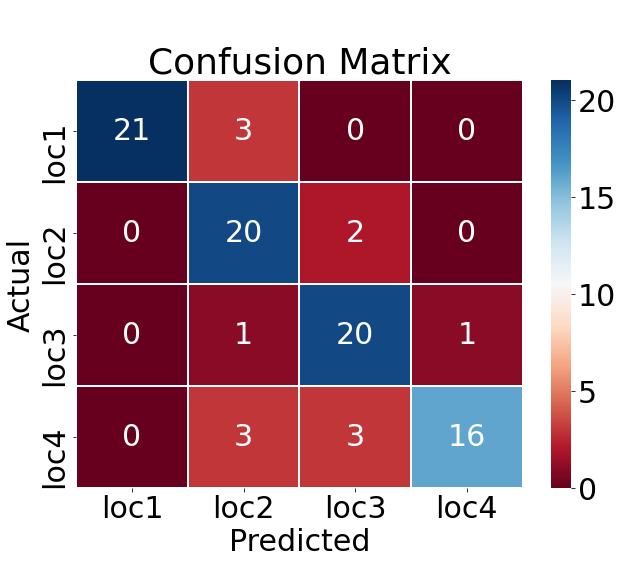

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       0.74      0.91      0.82        22
           2       0.80      0.91      0.85        22
           3       0.94      0.73      0.82        22

    accuracy                           0.86        90
   macro avg       0.87      0.86      0.86        90
weighted avg       0.87      0.86      0.86        90

=== Evaluation ========================================================
3/3 [==============================] - 0s 2ms/step - loss: 0.5521 - accuracy: 0.8556

Accuracy on test data: 85.555553

Loss on test data: 0.552


In [9]:

#Test the trained DNN model
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test,'')

print(classification_report(max_y_test, max_y_pred_test))

print("=== Evaluation ========================================================")
score = model.evaluate(x_test, y_test_hot, verbose=1)
print('\nAccuracy on test data: %0.6f' % (score[1]*100))
print('\nLoss on test data: %0.3f' % score[0])



In [10]:
type(max_y_pred_test)

numpy.ndarray

## Insert the predicted labels (locations) into the original dataframe

In [11]:
df_predicted_data = df_data.copy()
col_numb = df_predicted_data.columns.get_loc("location")
df_predicted_data.insert(loc=col_numb+1, column='dnnPredLoc', value=None, allow_duplicates = False)
df_predicted_data.insert(loc=col_numb+2, column='dnnPredLocGPS', value=None, allow_duplicates = False)

for device,seqNumber,pred_loc_code in zip(device_list,seqNumber_list,max_y_pred_test):
#     print(device,seqNumber,pred_loc_code)
    pred_loc = LABELS[pred_loc_code]
    pred_gps = LABELS_GPS[pred_loc_code]
    condition = (df_predicted_data['device']==device) & (df_predicted_data['seqNumber']==seqNumber)
    df_predicted_data.loc[condition,'dnnPredLoc'] = pred_loc
    df_predicted_data.loc[condition,'dnnPredLocGPS'] = pred_gps
#     break

display(df_predicted_data.head(2))
display(df_predicted_data.tail(2))


file location dnnPredLoc  \
39811  cleaned_nCr_rssi_tst_loc1_02.xlsx     loc1       loc1   
39812  cleaned_nCr_rssi_tst_loc1_02.xlsx     loc1       loc1   

             dnnPredLocGPS  Iteration             DateRecorded  \
39811  22.29321,114.172877          1  2020-01-02 14:49:25.802   
39812  22.29321,114.172877          1  2020-01-02 14:49:25.802   

                  TimeRecorded  device  seqNumber station  rssi  ExpectedRSSI  \
39811  2020-01-02 14:49:25.802  3E81CB       1183    6BFE  -123   -126.331345   
39812  2020-01-02 14:49:25.802  3E81CB       1183    6C6B   -91   -122.999950   

       DistanceBSandDevice    snr                      data        time  \
39811          8673.571830   9.11  01542ac806ce241800000000  1577947738   
39812          6528.493102  24.41  01542ac806ce241800000000  1577947738   

       BaseStationLat  BaseStationLng  BaseStationHeight BaseStationRegion  \
39811       22.362571      114.134226                 90   New Territories   
39812       22.308348      114.234173                102           Kowloon   

      SubDistrict  BaseStationX  BaseStationY  OriginGPSLat  OriginGPSLng  \
39811         xxx    23228.2883    21664.5076     22.167615    113.908514   
39812         xxx    33513.9487    15638.9706     22.167615    113.908514   

       PathLossExponent  ReferenceRSSI  DeviceLLSLat  DeviceLLSLng  \
39811               2.7            -20     22.301837    114.182338   
39812               2.7            -20     22.301837    114.182338   

         DeviceLLSX    DeviceLLSY  DeviceGPSLat  DeviceGPSLng  \
39811  28179.593273  14915.426636      22.29321    114.172877   
39812  28179.593273  14915.426636      22.29321    114.172877   

       LocalizationError  nCrPathLossExponent  nCrReferenceRSSI  \
39811        1366.421775             2.291546        -35.259594   
39812        1366.421775             2.291546        -35.259594   

       nCrDeviceLLSX  nCrDeviceLLSY  nCrDeviceLLSLat  nCrDeviceLLSLng  \
39811   28365.524105   14431.242355         22.29748       114.184145   
39812   28365.524105   14431.242355         22.29748       114.184145   

       nCrLocalizationError  
39811           1252.934808  
39812           1252.934808

file location dnnPredLoc  \
42600  cleaned_nCr_rssi_tst_loc4_02.xlsx     loc4       loc4   
42601  cleaned_nCr_rssi_tst_loc4_02.xlsx     loc4       loc4   

             dnnPredLocGPS  Iteration             DateRecorded  \
42600  22.29373,114.175408         22  2020-01-02 17:22:25.871   
42601  22.29373,114.175408          5  2020-01-02 17:22:25.871   

                  TimeRecorded  device  seqNumber station  rssi  ExpectedRSSI  \
42600  2020-01-02 17:22:25.871  3E81CB       1272    8141  -113   -117.687837   
42601  2020-01-02 17:22:25.871  3E81CB       1272    814E  -123   -125.712662   

       DistanceBSandDevice  snr                      data        time  \
42600          4150.190687  6.0  01542ce606ce2db000000000  1577956917   
42601          8227.800687  6.0  01542ce606ce2db000000000  1577956917   

       BaseStationLat  BaseStationLng  BaseStationHeight BaseStationRegion  \
42600       22.330951      114.172098                 26           Kowloon   
42601       22.352710      114.127076                 22   New Territories   

      SubDistrict  BaseStationX  BaseStationY  OriginGPSLat  OriginGPSLng  \
42600         xxx    27125.7396    18150.7315     22.167615    113.908514   
42601         xxx    22492.4735    20568.7029     22.167615    113.908514   

       PathLossExponent  ReferenceRSSI  DeviceLLSLat  DeviceLLSLng  \
42600               2.7            -20     22.316799    114.174896   
42601               2.7            -20     22.316799    114.174896   

         DeviceLLSX    DeviceLLSY  DeviceGPSLat  DeviceGPSLng  \
42600  27413.639991  16578.111287      22.29373    114.175408   
42601  27413.639991  16578.111287      22.29373    114.175408   

       LocalizationError  nCrPathLossExponent  nCrReferenceRSSI  \
42600         2564.10996             2.074042        -39.045829   
42601         2564.10996             2.074042        -39.045829   

       nCrDeviceLLSX  nCrDeviceLLSY  nCrDeviceLLSLat  nCrDeviceLLSLng  \
42600   27696.963868   14005.935518        22.293653       114.177649   
42601   27696.963868   14005.935518        22.293653       114.177649   

       nCrLocalizationError  
42600            230.748934  
42601            230.748934

## LE by normal approach VS LE by nCr approach

In [12]:
df = df_predicted_data.copy()
df = df.drop_duplicates(['nCrPathLossExponent','nCrReferenceRSSI'])
df = df.sort_values(['nCrLocalizationError'])
df1 = df.head(5)

print('\n=== Statistic of Localization Error by normal approach ==============')
print(df['LocalizationError'].describe())
print()
print("PathLossExponent:",df['PathLossExponent'].values[0])
print("ReferenceRSSI",df['ReferenceRSSI'].values[0])
print('\n=== Statistic of Localization Error by nCr approach ==============')
print(df['nCrLocalizationError'].describe())
# print(df1['nCrPathLossExponent'].describe())
# print(df1['nCrReferenceRSSI'].describe())
print('\n____ nCrPathLossExponent ')
print(df['nCrPathLossExponent'].describe())
print('\n____ nCrPathLossExponent')
print(df['nCrReferenceRSSI'].describe())



=== Statistic of Localization Error by normal approach ==============
count      90.000000
mean     2385.938595
std      1099.126816
min       740.721307
25%      1841.224502
50%      2318.824332
75%      2676.979879
max      7959.107298
Name: LocalizationError, dtype: float64

PathLossExponent: 2.7
ReferenceRSSI -20

=== Statistic of Localization Error by nCr approach ==============
count      90.000000
mean     1480.663799
std       897.301584
min        22.522378
25%       811.656106
50%      1516.994740
75%      2049.323587
max      5356.373559
Name: nCrLocalizationError, dtype: float64

____ nCrPathLossExponent 
count    90.000000
mean      2.871079
std       0.399107
min       2.028874
25%       2.775172
50%       3.037102
75%       3.112489
max       3.340282
Name: nCrPathLossExponent, dtype: float64

____ nCrPathLossExponent
count    90.000000
mean    -17.913325
std      18.463210
min     -52.196732
25%     -37.719135
50%      -6.635604
75%      -1.490016
max      -0.042455
Na

## Keep the good base stations
## i.e. Remove the bad base stations

In [13]:
def removeBadBS(dataframe=None):
    """
    Return 3 dataframes. 1st: df_good_bs, 2nd: df_bad_bs, 3rd: df_all_bs
    1. Calculate the high/low expected RSSI thresholds between ML predicted target GPS and BS GPS
    2. Keep good base stations (i.e. rows in DF) if the value of the measured RSSI is in between the high AND low thresholds
    """
    df = dataframe.copy()
#     df = df.sort_values(['dnnPredLoc','station'])
    #Insert a column to store the dnn expected RSSI
    col_numb = df.columns.get_loc("rssi")
    df.insert(loc=col_numb+1, column='dnnRSSIThresholdHigh', value=None, allow_duplicates = False)
    df.insert(loc=col_numb+2, column='dnnRSSIThresholdLow', value=None, allow_duplicates = False)
    #Set the origin of the x-y coord system
    origin_lat = df['OriginGPSLat'].values[0]
    origin_lng = df['OriginGPSLng'].values[0]
    coordsys = myCoordinateSystem.Location(origin_lat, origin_lng)
    #Calculate the high/low expected RSSI thresholds
    for location in LABELS:  #In each location
        condition = df['dnnPredLoc']==location
        bs_list = df.loc[condition,'station'].unique()
        print(location,"\tBS number:",len(bs_list),end="\tGPS:")
        for bsid in bs_list: #and rows under each BS
#             print(location,bsid)
            condition = (df['dnnPredLoc']==location) & (df['station']==bsid)
            df1 = df.loc[condition,:]
            #Calculate the high and low expected RSSI threshold
            ##Distance between this BS and the device GPS location
            bsgpslat = df1['BaseStationLat'].iloc[0]
            bsgpslng = df1['BaseStationLng'].iloc[0]
            devicegps = eval(df1['dnnPredLocGPS'].iloc[0])
            devicegpslat = devicegps[0]
            devicegpslng = devicegps[1]
            distance = coordsys.distance_btw2gps(lat1=bsgpslat, lng1=bsgpslng, lat2=devicegpslat, lng2=devicegpslng)
            #The expected RSSI of this distance
            alpha = df1['PathLossExponent'].iloc[0]#2.304500
            ref_rssi = df1['ReferenceRSSI'].iloc[0]#-37.490058
            distance_threshold = 300
            rssi_high_threshold = myRadioPropagation.log_Normal_RSSI_With_Distance(alpha=alpha,z0=ref_rssi,distance=distance-distance_threshold)
            rssi_low_threshold = myRadioPropagation.log_Normal_RSSI_With_Distance(alpha=alpha,z0=ref_rssi,distance=distance+distance_threshold)
            df.loc[condition,'dnnRSSIThresholdHigh'] = rssi_high_threshold
            df.loc[condition,'dnnRSSIThresholdLow'] = rssi_low_threshold            
        print(devicegpslat,devicegpslng)
#         break
    #Compare the measured RSSI with the high & low thresholds
    condition_gd_bs = (df['rssi'] <= df['dnnRSSIThresholdHigh']) & (df['rssi'] >= df['dnnRSSIThresholdLow'])
    df_good_bs = df[condition_gd_bs]
    df_good_bs = df_good_bs.groupby('seqNumber').filter(lambda x : len(x)>=3) #keep that measurement (i.e. unique device id and seqNumber) if number of BS >= 3
    df_bad_bs = df[~condition_gd_bs]
    df_all_bs = df

    #Show the performance
    print("\nAfter removing bad BS\nGood BS\n-------------------")
    for location in LABELS:
        df = df_good_bs[df_good_bs['location']==location]
        bs_list = df['station'].unique().tolist()
        print(location,"\tBS number:",len(bs_list))
    
    #Return a new df without bad BS
    return df_good_bs,df_bad_bs,df_all_bs

df_good_bs,df_bad_bs,df_all_bs = removeBadBS(df_predicted_data)



loc1 	BS number: 41	GPS:22.29321 114.172877
loc2 	BS number: 39	GPS:22.293025 114.173606
loc3 	BS number: 40	GPS:22.293381 114.175046
loc4 	BS number: 37	GPS:22.29373 114.175408

After removing bad BS
Good BS
-------------------
loc1 	BS number: 16
loc2 	BS number: 12
loc3 	BS number: 12
loc4 	BS number: 12


The number of BS in each measurement after 'good BS' kept

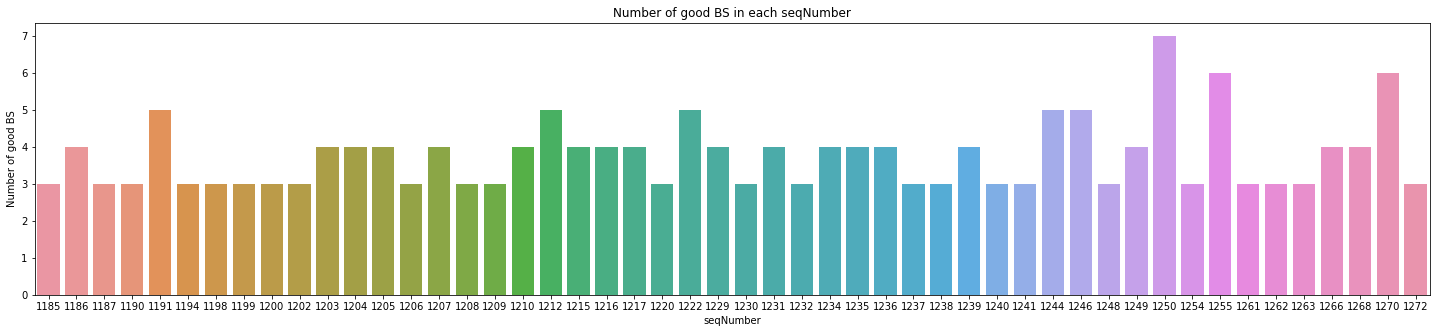

In [14]:

df_plot = df_good_bs['seqNumber'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(25, 5))
plt.rcParams.update({'font.size': 10})
fig = sns.barplot(x=df_plot.index,y=df_plot.values)

plt.xlabel("seqNumber")
plt.ylabel("Number of good BS")
plt.title("Number of good BS in each seqNumber")
plt.show(fig)


In [15]:
df_good_bs.head(2)

file location dnnPredLoc  \
39884  cleaned_nCr_rssi_tst_loc1_02.xlsx     loc1       loc1   
39892  cleaned_nCr_rssi_tst_loc1_02.xlsx     loc1       loc1   

             dnnPredLocGPS  Iteration             DateRecorded  \
39884  22.29321,114.172877          3  2020-01-02 14:53:26.811   
39892  22.29321,114.172877          3  2020-01-02 14:53:26.811   

                  TimeRecorded  device  seqNumber station  rssi  \
39884  2020-01-02 14:53:26.811  3E81CB       1185    6E12  -116   
39892  2020-01-02 14:53:26.811  3E81CB       1185    7C43   -90   

      dnnRSSIThresholdHigh dnnRSSIThresholdLow  ExpectedRSSI  \
39884             -114.262            -116.338   -115.345929   
39892             -83.5424            -98.7534    -93.458668   

       DistanceBSandDevice    snr                      data        time  \
39884          3398.839785  11.52  01542ad206ce23e000000000  1577947979   
39892           525.643612  12.79  01542ad206ce23e000000000  1577947979   

       BaseStationLat  BaseStationLng  BaseStationHeight BaseStationRegion  \
39884       22.322607      114.163759                 50           Kowloon   
39892       22.297508      114.170744                 53           Kowloon   

      SubDistrict  BaseStationX  BaseStationY  OriginGPSLat  OriginGPSLng  \
39884         xxx    26267.5635    17223.5036     22.167615    113.908514   
39892         xxx    26986.3979    14434.3744     22.167615    113.908514   

       PathLossExponent  ReferenceRSSI  DeviceLLSLat  DeviceLLSLng  \
39884               2.7            -20     22.309891    114.179184   
39892               2.7            -20     22.309891    114.179184   

         DeviceLLSX    DeviceLLSY  DeviceGPSLat  DeviceGPSLng  \
39884  27855.005191  15810.457822      22.29321    114.172877   
39892  27855.005191  15810.457822      22.29321    114.172877   

       LocalizationError  nCrPathLossExponent  nCrReferenceRSSI  \
39884        1964.059216             3.062055         -1.312332   
39892        1964.059216             3.062055         -1.312332   

       nCrDeviceLLSX  nCrDeviceLLSY  nCrDeviceLLSLat  nCrDeviceLLSLng  \
39884   28119.493716   15565.675639        22.307688       114.181754   
39892   28119.493716   15565.675639        22.307688       114.181754   

       nCrLocalizationError  
39884           1850.203732  
39892           1850.203732

## Perform LLS localization on the 'good BS' RSSI data

In [16]:
def mlLocalization(dataframe=None):
    """
    1. Reperform localization on the 'good BS' RSSI dataset.
    2. Find the ML estimated target GPS.
    3. The Localization Error is calculated by the real GPS of the device instead of the DNN predicted location.
    4. Return the input dataframe inserted with 'good BS' LLS localization results.
    """
    df = dataframe.copy()
    col_numb = df.columns.get_loc("LocalizationError")
    column_name_list = ['dnnDeviceLLSX','dnnDeviceLLSY','dnnDeviceLLSLat','dnnDeviceLLSLng','dnnLocalizationError']
    count = 1
    for col_name in column_name_list:
        df.insert(loc=col_numb+count, column=col_name, value=None, allow_duplicates = False)
        count = count + 1
    #Define some constant variables
    alpha = df['PathLossExponent'].iloc[0]#2.304500
    ref_rssi = df['ReferenceRSSI'].iloc[0]#-37.490058
    df1 = df.drop_duplicates(['device','seqNumber'],keep= 'last')
    new_device_list = df1['device']
    new_seqNumber_list = df1['seqNumber']
    #Perform LLS localization on the "good BS" dataframe
    for device,seqNumber in zip(new_device_list,new_seqNumber_list): #in each unique measurement (unique device ID and seqNumber)
#         print(device,seqNumber)
        condition = (df['device']==device) & (df['seqNumber']==seqNumber)
        df1 = df[condition]
        #Find the 'good BS' LLS localization result
        bs_coor_lat = df1['BaseStationLat'].tolist()
        bs_coor_lng = df1['BaseStationLng'].tolist()
        measured_rssi = df1['rssi'].tolist()
        device_gps_lat = df1['DeviceGPSLat'].iloc[0]
        device_gps_lng = df1['DeviceGPSLng'].iloc[0]
        performLLS = myLLS.LLS(alpha = alpha, Z0=ref_rssi, bsCoordinateLat=bs_coor_lat, bsCoordinateLng=bs_coor_lng,
                               measuredRssi=measured_rssi, targetRealGPS=[device_gps_lat,device_gps_lng])
        lls_results_dict = performLLS.allResultsGPS()
        #Save the 'good BS' LLS result into the input "good BS" dataframe
        df.loc[condition,'dnnDeviceLLSLat'] = lls_results_dict['llsLat']
        df.loc[condition,'dnnDeviceLLSLng'] = lls_results_dict['llsLng']
        df.loc[condition,'dnnDeviceLLSX'] = lls_results_dict['llsX']
        df.loc[condition,'dnnDeviceLLSY'] = lls_results_dict['llsY']
        df.loc[condition,'dnnLocalizationError'] = lls_results_dict['LE']
    return df

df_lls_result = mlLocalization(df_good_bs)
display(df_lls_result.head(2))
display(df_lls_result.tail(2))


file location dnnPredLoc  \
39884  cleaned_nCr_rssi_tst_loc1_02.xlsx     loc1       loc1   
39892  cleaned_nCr_rssi_tst_loc1_02.xlsx     loc1       loc1   

             dnnPredLocGPS  Iteration             DateRecorded  \
39884  22.29321,114.172877          3  2020-01-02 14:53:26.811   
39892  22.29321,114.172877          3  2020-01-02 14:53:26.811   

                  TimeRecorded  device  seqNumber station  rssi  \
39884  2020-01-02 14:53:26.811  3E81CB       1185    6E12  -116   
39892  2020-01-02 14:53:26.811  3E81CB       1185    7C43   -90   

      dnnRSSIThresholdHigh dnnRSSIThresholdLow  ExpectedRSSI  \
39884             -114.262            -116.338   -115.345929   
39892             -83.5424            -98.7534    -93.458668   

       DistanceBSandDevice    snr                      data        time  \
39884          3398.839785  11.52  01542ad206ce23e000000000  1577947979   
39892           525.643612  12.79  01542ad206ce23e000000000  1577947979   

       BaseStationLat  BaseStationLng  BaseStationHeight BaseStationRegion  \
39884       22.322607      114.163759                 50           Kowloon   
39892       22.297508      114.170744                 53           Kowloon   

      SubDistrict  BaseStationX  BaseStationY  OriginGPSLat  OriginGPSLng  \
39884         xxx    26267.5635    17223.5036     22.167615    113.908514   
39892         xxx    26986.3979    14434.3744     22.167615    113.908514   

       PathLossExponent  ReferenceRSSI  DeviceLLSLat  DeviceLLSLng  \
39884               2.7            -20     22.309891    114.179184   
39892               2.7            -20     22.309891    114.179184   

         DeviceLLSX    DeviceLLSY  DeviceGPSLat  DeviceGPSLng  \
39884  27855.005191  15810.457822      22.29321    114.172877   
39892  27855.005191  15810.457822      22.29321    114.172877   

       LocalizationError dnnDeviceLLSX dnnDeviceLLSY dnnDeviceLLSLat  \
39884        1964.059216       27625.4       13798.4         22.2918   
39892        1964.059216       27625.4       13798.4         22.2918   

      dnnDeviceLLSLng dnnLocalizationError  nCrPathLossExponent  \
39884         114.177              448.367             3.062055   
39892         114.177              448.367             3.062055   

       nCrReferenceRSSI  nCrDeviceLLSX  nCrDeviceLLSY  nCrDeviceLLSLat  \
39884         -1.312332   28119.493716   15565.675639        22.307688   
39892         -1.312332   28119.493716   15565.675639        22.307688   

       nCrDeviceLLSLng  nCrLocalizationError  
39884       114.181754           1850.203732  
39892       114.181754           1850.203732

file location dnnPredLoc  \
42591  cleaned_nCr_rssi_tst_loc4_02.xlsx     loc4       loc4   
42592  cleaned_nCr_rssi_tst_loc4_02.xlsx     loc4       loc4   

             dnnPredLocGPS  Iteration             DateRecorded  \
42591  22.29373,114.175408         22  2020-01-02 17:22:25.871   
42592  22.29373,114.175408         21  2020-01-02 17:22:25.871   

                  TimeRecorded  device  seqNumber station  rssi  \
42591  2020-01-02 17:22:25.871  3E81CB       1272    7F27   -96   
42592  2020-01-02 17:22:25.871  3E81CB       1272    8041  -113   

      dnnRSSIThresholdHigh dnnRSSIThresholdLow  ExpectedRSSI  \
42591               -93.76            -102.529    -98.946116   
42592             -111.798             -114.31   -113.120951   

       DistanceBSandDevice   snr                      data        time  \
42591           839.325142  6.26  01542ce606ce2db000000000  1577956917   
42592          2811.409537  6.00  01542ce606ce2db000000000  1577956917   

       BaseStationLat  BaseStationLng  BaseStationHeight BaseStationRegion  \
42591       22.300567      114.178874                 39           Kowloon   
42592       22.286859      114.149116                 75  Hong Kong Island   

      SubDistrict  BaseStationX  BaseStationY  OriginGPSLat  OriginGPSLng  \
42591         xxx    27823.0656    14774.3061     22.167615    113.908514   
42592  Sheung Wan    24760.6355    13251.0030     22.167615    113.908514   

       PathLossExponent  ReferenceRSSI  DeviceLLSLat  DeviceLLSLng  \
42591               2.7            -20     22.316799    114.174896   
42592               2.7            -20     22.316799    114.174896   

         DeviceLLSX    DeviceLLSY  DeviceGPSLat  DeviceGPSLng  \
42591  27413.639991  16578.111287      22.29373    114.175408   
42592  27413.639991  16578.111287      22.29373    114.175408   

       LocalizationError dnnDeviceLLSX dnnDeviceLLSY dnnDeviceLLSLat  \
42591         2564.10996       28134.8         12709          22.282   
42592         2564.10996       28134.8         12709          22.282   

      dnnDeviceLLSLng dnnLocalizationError  nCrPathLossExponent  \
42591         114.182              1466.72             2.074042   
42592         114.182              1466.72             2.074042   

       nCrReferenceRSSI  nCrDeviceLLSX  nCrDeviceLLSY  nCrDeviceLLSLat  \
42591        -39.045829   27696.963868   14005.935518        22.293653   
42592        -39.045829   27696.963868   14005.935518        22.293653   

       nCrDeviceLLSLng  nCrLocalizationError  
42591       114.177649            230.748934  
42592       114.177649            230.748934

## Compare the performance of the normal LLS, nCr best alpha & ref RSSI LLS, SVM LLS, DNN LLS and CNN LLS

In [17]:
#Import the most common plotly libraries
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
# Activate inline plotting in notebook
py.init_notebook_mode(connected = False)

### Prepare Data for plotting

In [18]:
def prepareData(dataframe=None):
    #Extract the rows with unique 'device ID and seqNumber'
    df = dataframe.copy()
    df = df.drop_duplicates(['device','seqNumber'],keep='last')
    df = df.sort_values(['location','device','seqNumber'])
    df = df.reset_index(drop=True)
    df = df[['location','DeviceGPSLat','DeviceGPSLng','device','seqNumber','time',
             'DeviceLLSLat','DeviceLLSLng','LocalizationError',
             'nCrDeviceLLSLat','nCrDeviceLLSLng','nCrLocalizationError',
             'dnnDeviceLLSLat','dnnDeviceLLSLng','dnnLocalizationError']]

    index = df.index
    #Declare a dict to store the min/max of LE
    le_dict = {'normal':    dict(),
               'best_a_z0': dict(),
#                'svm_gd_bs': dict(),
               'dnn_gd_bs': dict(),
#                'cnn_gd_bs': dict()
              }
    #LLS of normal RSSI
    #Find the max/min of localization error 
    df_le = df['LocalizationError']
    key = 'normal'
    le_dict[key]['min'] = df_le.min()
    le_dict[key]['max'] = df_le.max()
    le_dict[key]['min_gps'] = df.loc[df_le==df_le.min()][['DeviceLLSLat','DeviceLLSLng']].to_numpy().tolist()[0]
    le_dict[key]['min_seq'] = df.loc[df_le==df_le.min()].index.values[0]
    le_dict[key]['max_seq'] = df.loc[df_le==df_le.max()].index.values[0]

    #LLS of nCr best alpha & ref RSSI
    #Find the max/min of localization error
    df_le = df['nCrLocalizationError']
    key = 'best_a_z0'
    le_dict[key]['min'] = df_le.min()
    le_dict[key]['max'] = df_le.max()
    le_dict[key]['min_gps'] = df.loc[df_le==df_le.min()][['nCrDeviceLLSLat','nCrDeviceLLSLng']].to_numpy().tolist()[0]
    le_dict[key]['min_seq'] = df.loc[df_le==df_le.min()].index.values[0]
    le_dict[key]['max_seq'] = df.loc[df_le==df_le.max()].index.values[0]

    #LLS of DNN good BS RSSI
    #Find the max/min of localization error
    df_le = df['dnnLocalizationError']
    key = 'dnn_gd_bs'
    le_dict[key]['min'] = df_le.min()
    le_dict[key]['max'] = df_le.max()
    le_dict[key]['min_gps'] = df.loc[df_le==df_le.min()][['dnnDeviceLLSLat','dnnDeviceLLSLng']].to_numpy().tolist()[0]
    le_dict[key]['min_seq'] = df.loc[df_le==df_le.min()].index.values[0]
    le_dict[key]['max_seq'] = df.loc[df_le==df_le.max()].index.values[0]
    
    return df,le_dict,index

#Useless, Just for testing
df_temp,le_dict,index = prepareData(df_lls_result)
print(le_dict)
print()
for key,a_dict in le_dict.items():
    print("=== LE by {} ===".format(key))
    for key,val in a_dict.items():
        print(key+":",val)
    print()
df_temp.head(5)


{'normal': {'min': 740.7213071350928, 'max': 7959.107297874066, 'min_gps': [22.2982439767182, 114.1775949426232], 'min_seq': 5, 'max_seq': 22}, 'best_a_z0': {'min': 22.52237780957853, 'max': 5356.373559315426, 'min_gps': [22.29317910111731, 114.1750651448957], 'min_seq': 39, 'max_seq': 9}, 'dnn_gd_bs': {'min': 72.23349391289169, 'max': 6666.681285435731, 'min_gps': [22.292767741701187, 114.17481330114846], 'min_seq': 40, 'max_seq': 16}}

=== LE by normal ===
min: 740.7213071350928
max: 7959.107297874066
min_gps: [22.2982439767182, 114.1775949426232]
min_seq: 5
max_seq: 22

=== LE by best_a_z0 ===
min: 22.52237780957853
max: 5356.373559315426
min_gps: [22.29317910111731, 114.1750651448957]
min_seq: 39
max_seq: 9

=== LE by dnn_gd_bs ===
min: 72.23349391289169
max: 6666.681285435731
min_gps: [22.292767741701187, 114.17481330114846]
min_seq: 40
max_seq: 16



location  DeviceGPSLat  DeviceGPSLng  device  seqNumber        time  \
0     loc1      22.29321    114.172877  3E81CB       1185  1577947979   
1     loc1      22.29321    114.172877  3E81CB       1186  1577948112   
2     loc1      22.29321    114.172877  3E81CB       1187  1577948229   
3     loc1      22.29321    114.172877  3E81CB       1190  1577948460   
4     loc1      22.29321    114.172877  3E81CB       1191  1577948542   

   DeviceLLSLat  DeviceLLSLng  LocalizationError  nCrDeviceLLSLat  \
0     22.309891    114.179184        1964.059216        22.307688   
1     22.306061    114.178346        1535.020513        22.300482   
2     22.299252    114.185877        1496.876452        22.300254   
3     22.307194    114.177036        1611.808924        22.294296   
4     22.306734    114.176778        1555.595179        22.296404   

   nCrDeviceLLSLng  nCrLocalizationError dnnDeviceLLSLat dnnDeviceLLSLng  \
0       114.181754           1850.203732         22.2918         114.177   
1       114.182042           1242.016615         22.2931         114.174   
2       114.184731           1449.477427         22.2945         114.174   
3       114.179288            670.761545         22.2927         114.177   
4       114.180909            899.519206          22.293         114.178   

  dnnLocalizationError  
0              448.367  
1              93.9719  
2              207.307  
3              433.048  
4              561.195

### Text version - LE Distribution of different approaches

In [19]:

print("=== LE distribution of Normal LLS ===========================")
print(df_temp['LocalizationError'].describe())
print()

print("=== LE distribution of nCr best alpha & red RSSI LLS ===========================")
print(df_temp['nCrLocalizationError'].describe())
print()

print("=== LE distribution of DNN LLS ===========================")
print(df_temp['dnnLocalizationError'].astype(float).describe())
print()


=== LE distribution of Normal LLS ===========================
count      50.000000
mean     2462.733098
std      1361.355545
min       740.721307
25%      1710.964469
50%      2318.824332
75%      2756.827304
max      7959.107298
Name: LocalizationError, dtype: float64

=== LE distribution of nCr best alpha & red RSSI LLS ===========================
count      50.000000
mean     1486.831143
std      1018.304401
min        22.522378
25%       622.108940
50%      1526.841626
75%      2095.429916
max      5356.373559
Name: nCrLocalizationError, dtype: float64

=== LE distribution of DNN LLS ===========================
count      50.000000
mean      673.077791
std      1062.436803
min        72.233494
25%       209.160390
50%       366.468563
75%       559.352898
max      6666.681285
Name: dnnLocalizationError, dtype: float64



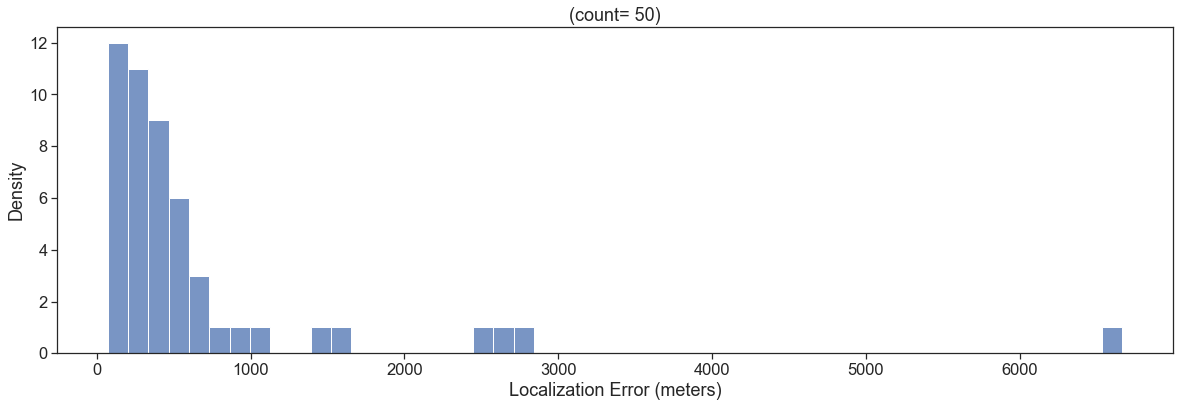

In [20]:

def Distplot(series, binsNumb=50):
    bsCount = str(len(series))
    sns.set(font_scale=1.5, style='ticks')
    f, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,6))

    #Dist plot
    from scipy.stats import norm
    sns.histplot(series,
#                  hist=True, 
                 kde=False, bins=binsNumb,
#                  norm_hist=False, 
#                 fit=norm,
#                 hist_kws={'edgecolor':'black'}, 
                 kde_kws={'linewidth': 5, 'color':'red',"label":"PDF"})
    plt.title('(count= '+bsCount+')',y=1)
    plt.xlabel('Localization Error (meters)')
    plt.ylabel('Density')
    plt.show()

series = df_temp['dnnLocalizationError'].astype(float).copy()
Distplot(series)
df_temp.to_csv('le_dnn.csv')

### Graphic version - LE Distribution of different approaches

In [21]:
def plotyLE(dataframe=None):
    df,le_dict,index = prepareData(dataframe.copy())
    print(df['location'].unique().tolist())
    lat = df['DeviceGPSLat'].unique().tolist()
    lng = df['DeviceGPSLng'].unique().tolist()
    print(lat)
    print(lng)
    #Initialize figure
    fig = go.Figure()
    # fig.add_trace(
    #     go.Bar(name='lls (normal rssi)', x=time, y=lls_df['LE'], marker_color='rgb(210,0,0)'), 
    # #     row=count_ax_row, 
    # #     col=count_ax_col
    # )    
    # fig.add_trace(
    #     go.Bar(name='lls (biased rssi)', x=time, y=lls_df['LE'], marker_color='green'), 
    # #     row=count_ax_row, 
    # #     col=count_ax_col
    # )
    fig.add_trace(
        go.Scatter(
            x=index, 
            y=df['LocalizationError'],
            mode='lines+markers',
            line = dict(color='grey',width=3),
            marker=dict(size=8),
            name='LE (normal LLS)',
            legendgroup="group1",
            text='normal rssi',
            textposition='top center'
            ), 
    )
    fig.add_trace(
        go.Scatter(
            x=index, 
            y=df['nCrLocalizationError'],
            mode='lines+markers',
            opacity=0.5,
            line = dict(color='green',width=3),
            marker=dict(size=8),
            name='LE (best alpha & z0)',
            legendgroup="group2",
            text='best alpha & z0',
            ), 
    )
    fig.add_trace(
        go.Scatter(
            x=index, 
            y=df['dnnLocalizationError'],
            mode='lines+markers',
            line = dict(color='blue',width=4),
            marker=dict(size=9),
            name='LE (DNN good BS)',
            legendgroup="group3",
            text='DNN good BS',
            ),
    )

    # Update xaxis properties
    # ==> https://plot.ly/python/axes/
    fig.update_xaxes(title_text="Index of measurement (seqNumber)", tickwidth=2)

    # Update yaxis properties
    # ==> https://plot.ly/python/axes/
    fig.update_yaxes(title_text="Localization Error (meter)")

    # Update title and height
    fig.update_layout(
        barmode='group',
    #     plot_bgcolor='white',
        height=700,
        width=1000,
    #     font_size=7.5,
        title={
            'text': "LE (Data:{0}, dnn:{1})".format(normalized_test_filepath,dnn_filepath),
            'font': {'size':12}
        },
        legend=dict(
            x=0,
            y=1,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="black"
            ),
            bgcolor="White",
            bordercolor="Black",
            borderwidth=2
        ),
        annotations=[
            dict(
                x=le_dict['normal']['max_seq'], y=le_dict['normal']['max'], xref='x', yref='y', 
                text='max='+str(int(le_dict['normal']['max'])),
                showarrow=True, font=dict(family='Courier New, monospace', size=16, color='#ffffff'),
                align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='black', ax=20, ay=-30, 
                bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='grey', opacity=0.8
            ),
            dict(
                x=le_dict['normal']['min_seq'], y=le_dict['normal']['min'], xref='x', yref='y',
                text='min='+str(int(le_dict['normal']['min'])),
                showarrow=True, font=dict(family='Courier New, monospace', size=16, color='#ffffff'),
                align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='black', ax=20, ay=40,
                bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='grey', opacity=0.8
            ),
            dict(
                x=le_dict['best_a_z0']['max_seq'], y=le_dict['best_a_z0']['max'], xref='x', yref='y',
                text='max='+str(int(le_dict['best_a_z0']['max'])),
                showarrow=True, font=dict(family='Courier New, monospace', size=16, color='#ffffff'),
                align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='black', ax=20, ay=-30,
                bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='green', opacity=0.8
            ),
            dict(
                x=le_dict['best_a_z0']['min_seq'], y=le_dict['best_a_z0']['min'], xref='x', yref='y',
                text='min='+str(int(le_dict['best_a_z0']['min'])),
                showarrow=True, font=dict(family='Courier New, monospace', size=16, color='#ffffff'),
                align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='black', ax=-30, ay=40,
                bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='green', opacity=0.8
            ),
            dict(
                x=le_dict['dnn_gd_bs']['max_seq'], y=le_dict['dnn_gd_bs']['max'], xref='x', yref='y',
                text='max='+str(int(le_dict['dnn_gd_bs']['max'])),
                showarrow=True, font=dict(family='Courier New, monospace', size=16, color='#ffffff'),
                align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='black', ax=20, ay=-30,
                bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='blue', opacity=0.8
            ),
            dict(
                x=le_dict['dnn_gd_bs']['min_seq'], y=le_dict['dnn_gd_bs']['min'], xref='x', yref='y',
                text='min='+str(int(le_dict['dnn_gd_bs']['min'])),
                showarrow=True, font=dict(family='Courier New, monospace', size=16, color='#ffffff'),
                align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='black', ax=20, ay=30,
                bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='blue', opacity=0.8
            )        
        ]
    )

    fig.show()


In [22]:
#Show LE of each location
for location in LABELS:
    condition = df_lls_result['location']==location
    df_plot = df_lls_result[condition]
    plotyLE(df_plot)

# Show LE of all locations (loc1 ~ loc4)
df_plot = df_lls_result
plotyLE(df_plot)

['loc1']
[22.29321]
[114.172877]


['loc2']
[22.293025]
[114.173606]


['loc3']
[22.293381]
[114.175046]


['loc4']
[22.29373]
[114.175408]


['loc1', 'loc2', 'loc3', 'loc4']
[22.29321, 22.293025, 22.293381, 22.29373]
[114.172877, 114.173606, 114.175046, 114.175408]


In [23]:
for location in LABELS:
    df = df_lls_result.copy()
    df = df[df['location']==location]
    df,le_dict,index = prepareData(df)
    print('{} {:7}{:15}{:}'.format(location,"LLS","min LE","LLS GPS"))
    print("=========================================")
    for key,a_dict in le_dict.items():
        lat = a_dict['min_gps'][0]
        lng = a_dict['min_gps'][1]
        LE = round(a_dict['min'])
        print('{:10}{:8}{:12f},{:f}'.format(key,LE,lat,lng))
    print("\n\n")

loc1 LLS    min LE         LLS GPS
normal       741.0   22.298244,114.177595
best_a_z0    182.0   22.293284,114.174645
dnn_gd_bs       94   22.293125,114.173786



loc2 LLS    min LE         LLS GPS
normal       867.0   22.286877,114.178788
best_a_z0     69.0   22.293097,114.172942
dnn_gd_bs      101   22.292127,114.173780



loc3 LLS    min LE         LLS GPS
normal       934.0   22.296049,114.183656
best_a_z0     23.0   22.293179,114.175065
dnn_gd_bs       72   22.292768,114.174813



loc4 LLS    min LE         LLS GPS
normal      1657.0   22.308641,114.175029
best_a_z0    231.0   22.293653,114.177649
dnn_gd_bs      109   22.292821,114.175811





In [24]:
for location in LABELS:
    print(location)
    print("=========================================")
    df = df_lls_result.copy()
    df = df[df['location']==location]
    df,le_dict,index = prepareData(df)
    print('{:13}{:15}{:}'.format("LLS","min LE","LLS GPS"))
    print("-----------------------------------------")
    
    for key,a_dict in le_dict.items():
        if key != 'best_a_z0':
            lat = a_dict['min_gps'][0]
            lng = a_dict['min_gps'][1]
            LE = round(a_dict['min'])
            print('{:10}{:8}{:12f},{:f}'.format(key,LE,lat,lng))
    print("=========================================\n")

loc1
LLS          min LE         LLS GPS
-----------------------------------------
normal       741.0   22.298244,114.177595
dnn_gd_bs       94   22.293125,114.173786

loc2
LLS          min LE         LLS GPS
-----------------------------------------
normal       867.0   22.286877,114.178788
dnn_gd_bs      101   22.292127,114.173780

loc3
LLS          min LE         LLS GPS
-----------------------------------------
normal       934.0   22.296049,114.183656
dnn_gd_bs       72   22.292768,114.174813

loc4
LLS          min LE         LLS GPS
-----------------------------------------
normal      1657.0   22.308641,114.175029
dnn_gd_bs      109   22.292821,114.175811



## Localization results in Google Map
From the link below

==> https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html#markers-and-symbols

In [25]:
#Change the location here to plot another localization result in the map
location='loc3'
data_df = df_lls_result.copy()
filename_data_df = data_df['file'].unique().tolist()
bias_data_name = ''
data_df = data_df[data_df['location']==location]
data_df = data_df.drop_duplicates(['device','seqNumber'],keep='last')
df,le_dict,index = prepareData(data_df)

gps = le_dict['normal']['min_gps']
print((gps[0],gps[1]))
le_dict


(22.29604929321801, 114.1836562694208)


{'normal': {'min': 934.3880814397739,
  'max': 3151.793721333393,
  'min_gps': [22.29604929321801, 114.1836562694208],
  'min_seq': 10,
  'max_seq': 7},
 'best_a_z0': {'min': 22.52237780957853,
  'max': 2477.394883000059,
  'min_gps': [22.29317910111731, 114.1750651448957],
  'min_seq': 15,
  'max_seq': 11},
 'dnn_gd_bs': {'min': 72.23349391289169,
  'max': 1584.173291141556,
  'min_gps': [22.292767741701187, 114.17481330114846],
  'min_seq': 16,
  'max_seq': 10}}

In [26]:
real_gps_lat = data_df['DeviceGPSLat'].values[0]
real_gps_lng = data_df['DeviceGPSLng'].values[0]
real_gps = (real_gps_lat,real_gps_lng)

print("Data: {0}".format(filename_data_df))
print("Bias: {0}".format(bias_data_name))
print("Note")
print("Real location:\tGPS{0}".format(real_gps))
print("Grey dot:\tLLS (normal)\t\tmin LE:",le_dict['normal']['min'])
# print("Green dot:\tLLS (best alpha & z0)\tmin LE:",le_dict['best_a_z0']['min'])
print("Blue dot:\tLLS (DNN good BS)\tmin LE:",le_dict['dnn_gd_bs']['min'])

#From the link below
#==> https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html#markers-and-symbols
import gmaps
gmaps.configure(api_key='AI...')


# gps_lls = data_df[['DeviceLLSLat', 'DeviceLLSLng']].apply(tuple, axis=1).to_list()
# gps_lls_best_a_z0 = data_df[['dnnDeviceLLSLat', 'dnnDeviceLLSLng']].dropna().apply(tuple, axis=1).to_list()
# gps_lls_dnn_gd_bs = data_df[['nCrDeviceLLSLat', 'nCrDeviceLLSLng']].dropna().apply(tuple, axis=1).to_list()
gps = le_dict['normal']['min_gps']
gps_lls = [(gps[0],gps[1])]
gps = le_dict['best_a_z0']['min_gps']
gps_lls_best_a_z0 = [(gps[0],gps[1])]
gps = le_dict['dnn_gd_bs']['min_gps']
gps_lls_dnn_gd_bs = [(gps[0],gps[1])]
print(gps_lls)
# print(gps_lls_best_a_z0)
print(gps_lls_dnn_gd_bs)

info_box_template = """
<dt>Loc</dt><dd>{name}</dd>
<dt>GPS</dt><dd>{gps}</dd>
""".format(name=location,gps=str(real_gps),bias=bias_data_name)
markers = gmaps.marker_layer([real_gps], info_box_content=info_box_template)
marker_layer1 = gmaps.symbol_layer(
    gps_lls,fill_color='white',
    stroke_color='rgb(128,128,128)', scale=10
)
marker_layer2 = gmaps.symbol_layer(
    gps_lls_best_a_z0, fill_color='white',
    stroke_color='green', scale=10
)
marker_layer3 = gmaps.symbol_layer(
    gps_lls_dnn_gd_bs, fill_color='white',
    stroke_color='blue', scale=10
)
figure_layout = {
    'width': '800px',
    'height': '600px',
}
fig = gmaps.figure(layout=figure_layout)#,center=real_gps,zoom_level=13)
fig.add_layer(markers)
fig.add_layer(marker_layer1)
# fig.add_layer(marker_layer2)
fig.add_layer(marker_layer3)
fig


Data: ['cleaned_nCr_rssi_tst_loc1_02.xlsx', 'cleaned_nCr_rssi_tst_loc2_02.xlsx', 'cleaned_nCr_rssi_tst_loc3_02.xlsx', 'cleaned_nCr_rssi_tst_loc4_02.xlsx']
Bias: 
Note
Real location:	GPS(22.293381, 114.175046)
Grey dot:	LLS (normal)		min LE: 934.3880814397739
Blue dot:	LLS (DNN good BS)	min LE: 72.23349391289169
[(22.29604929321801, 114.1836562694208)]
[(22.292767741701187, 114.17481330114846)]


Figure(layout=FigureLayout(height='600px', width='800px'))

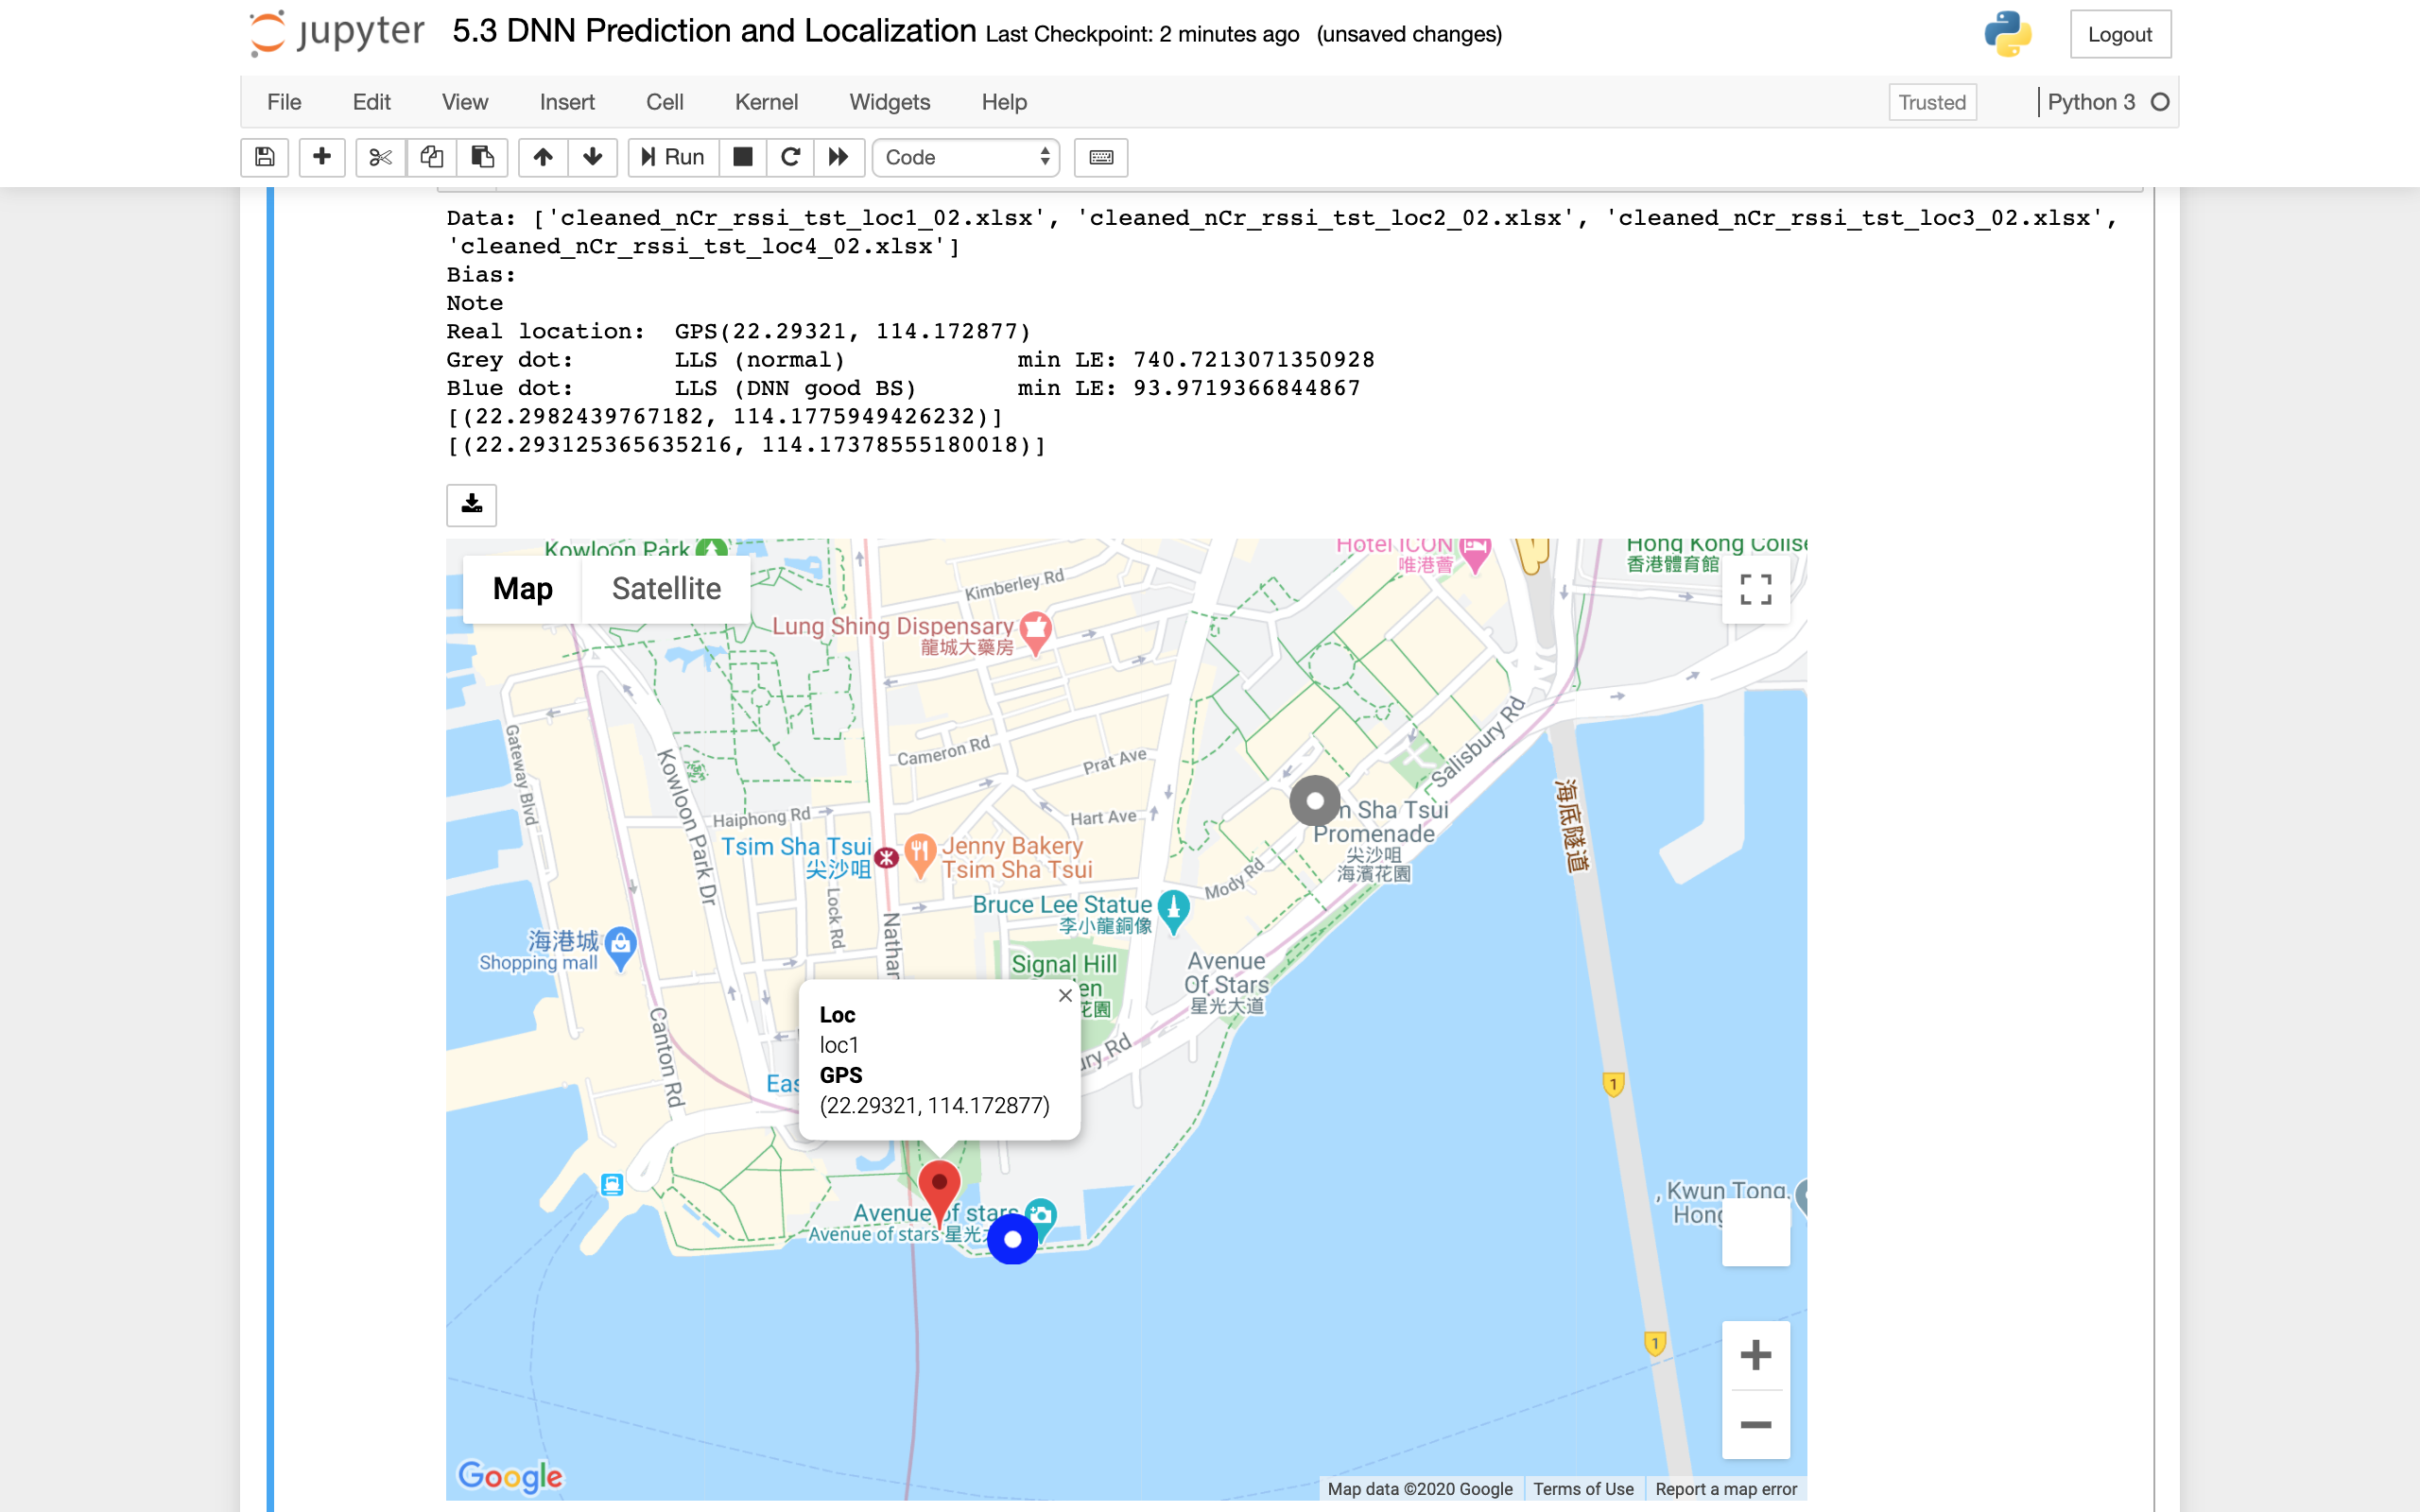

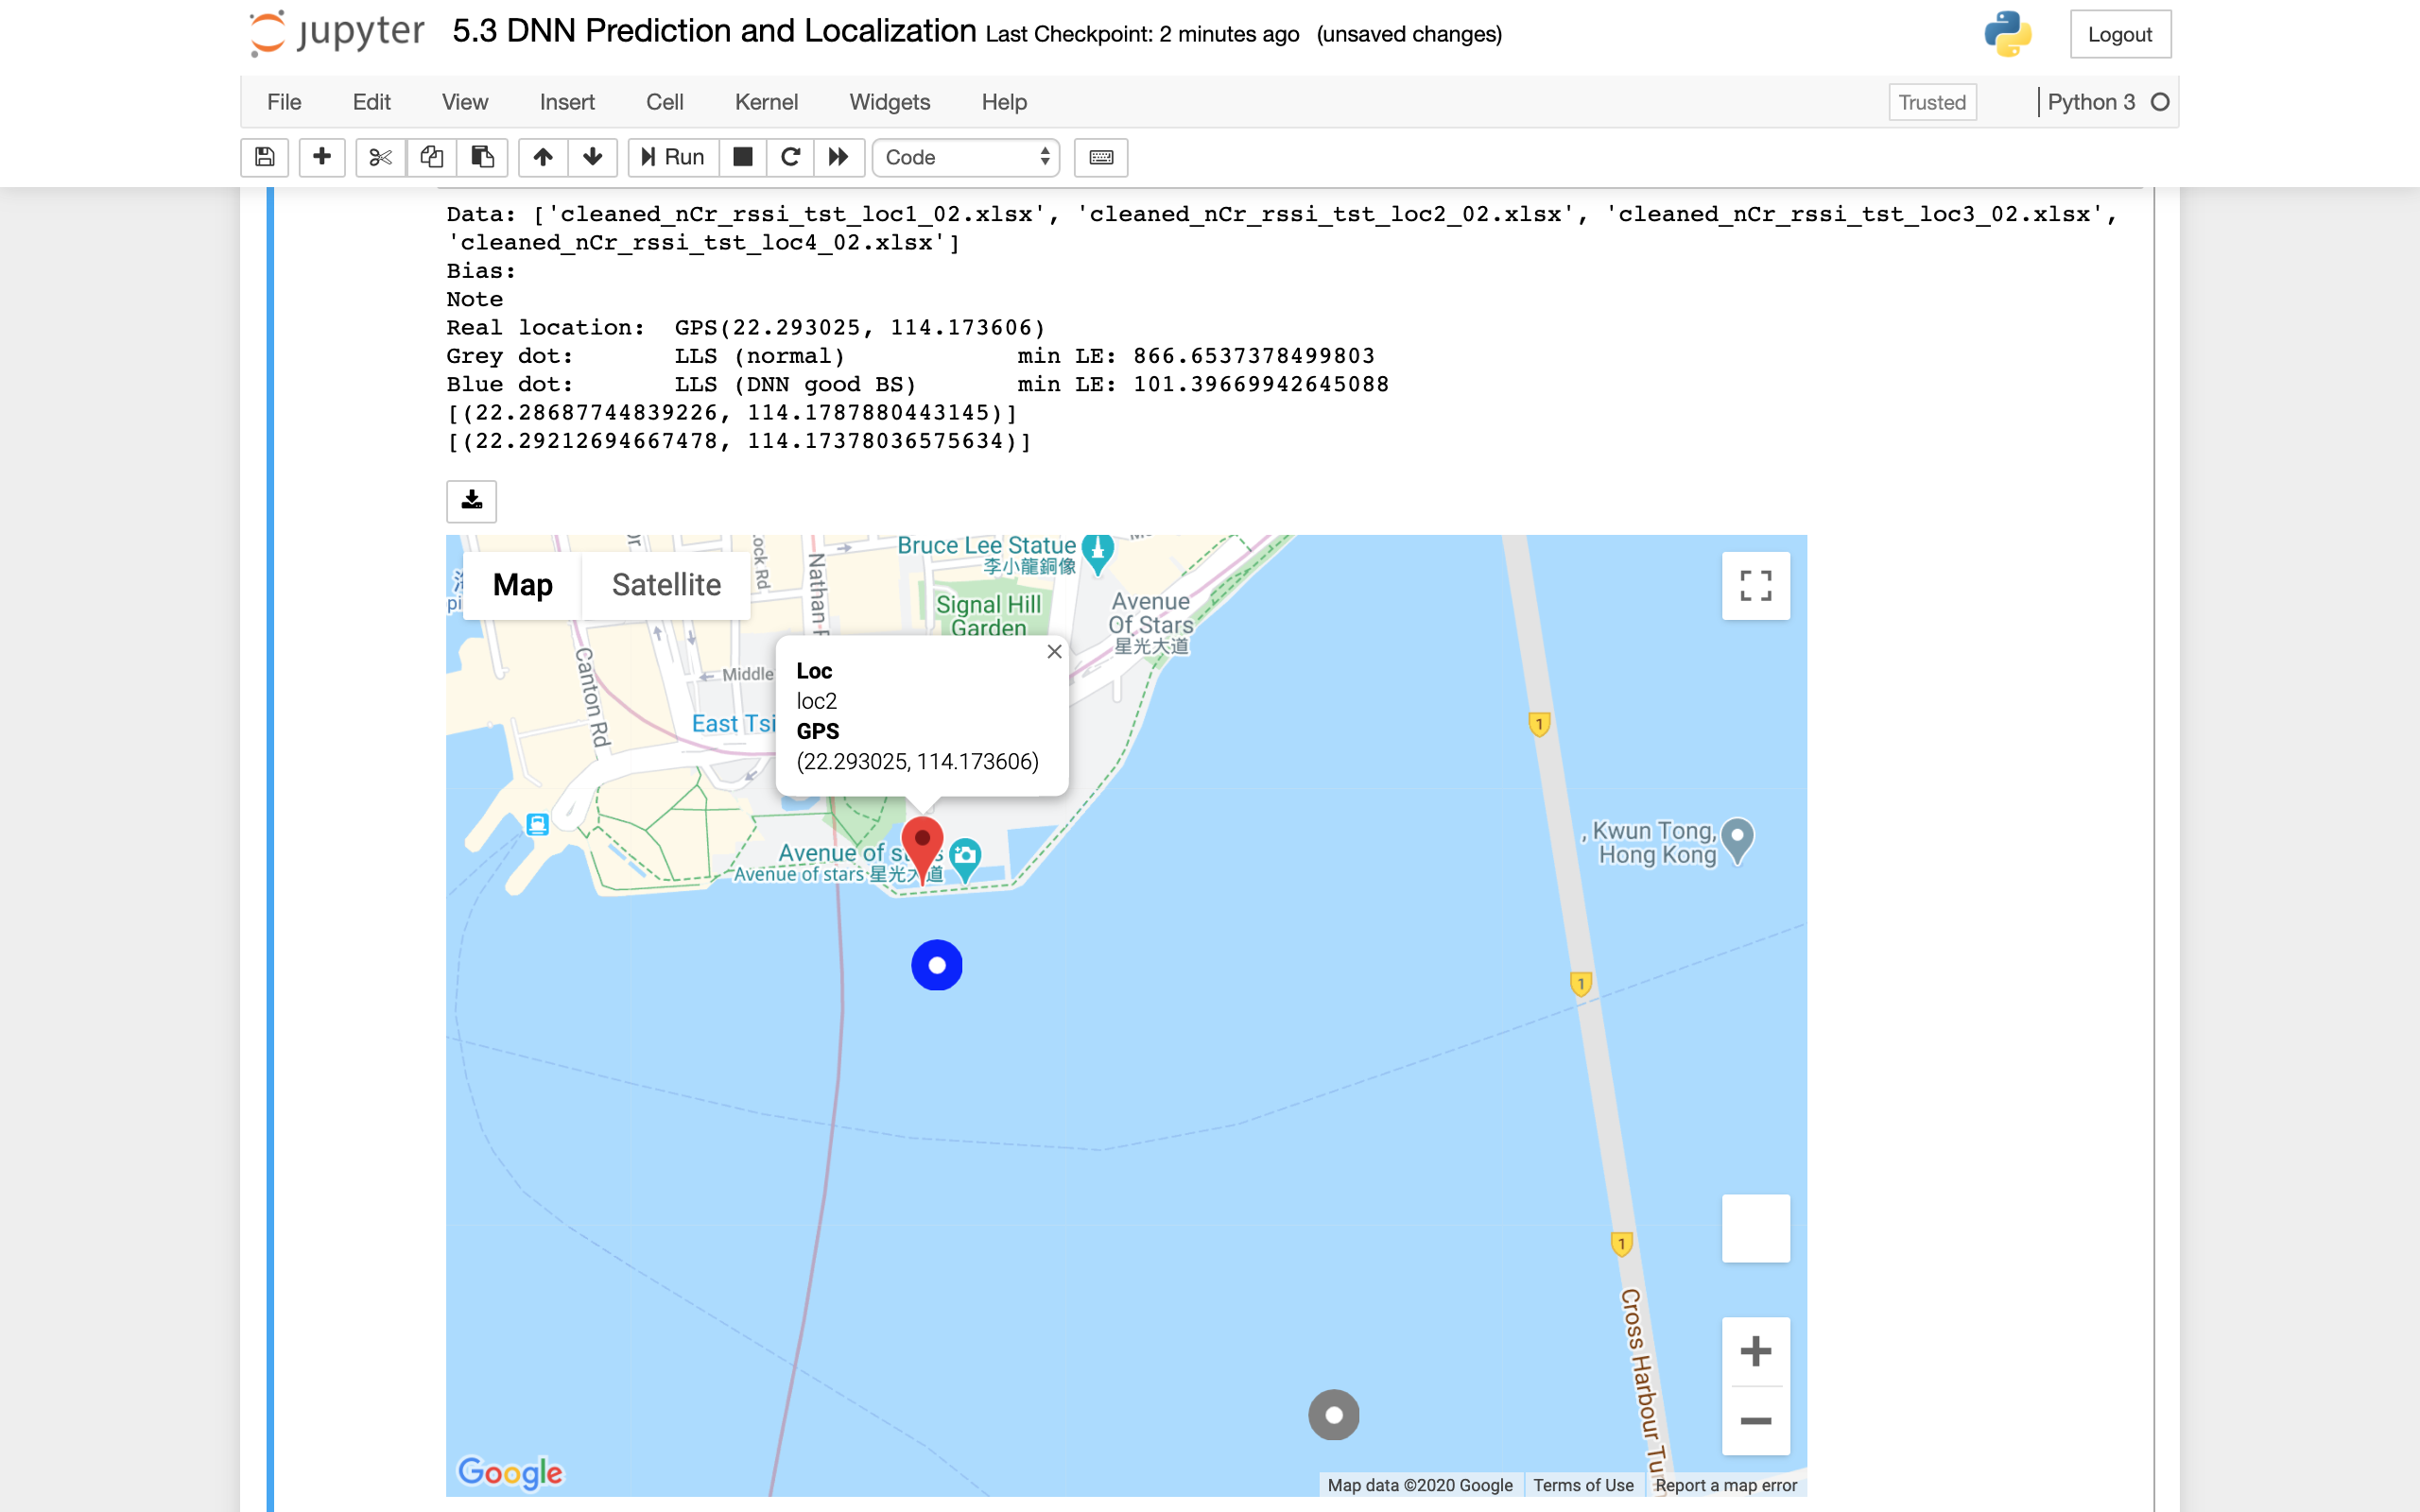

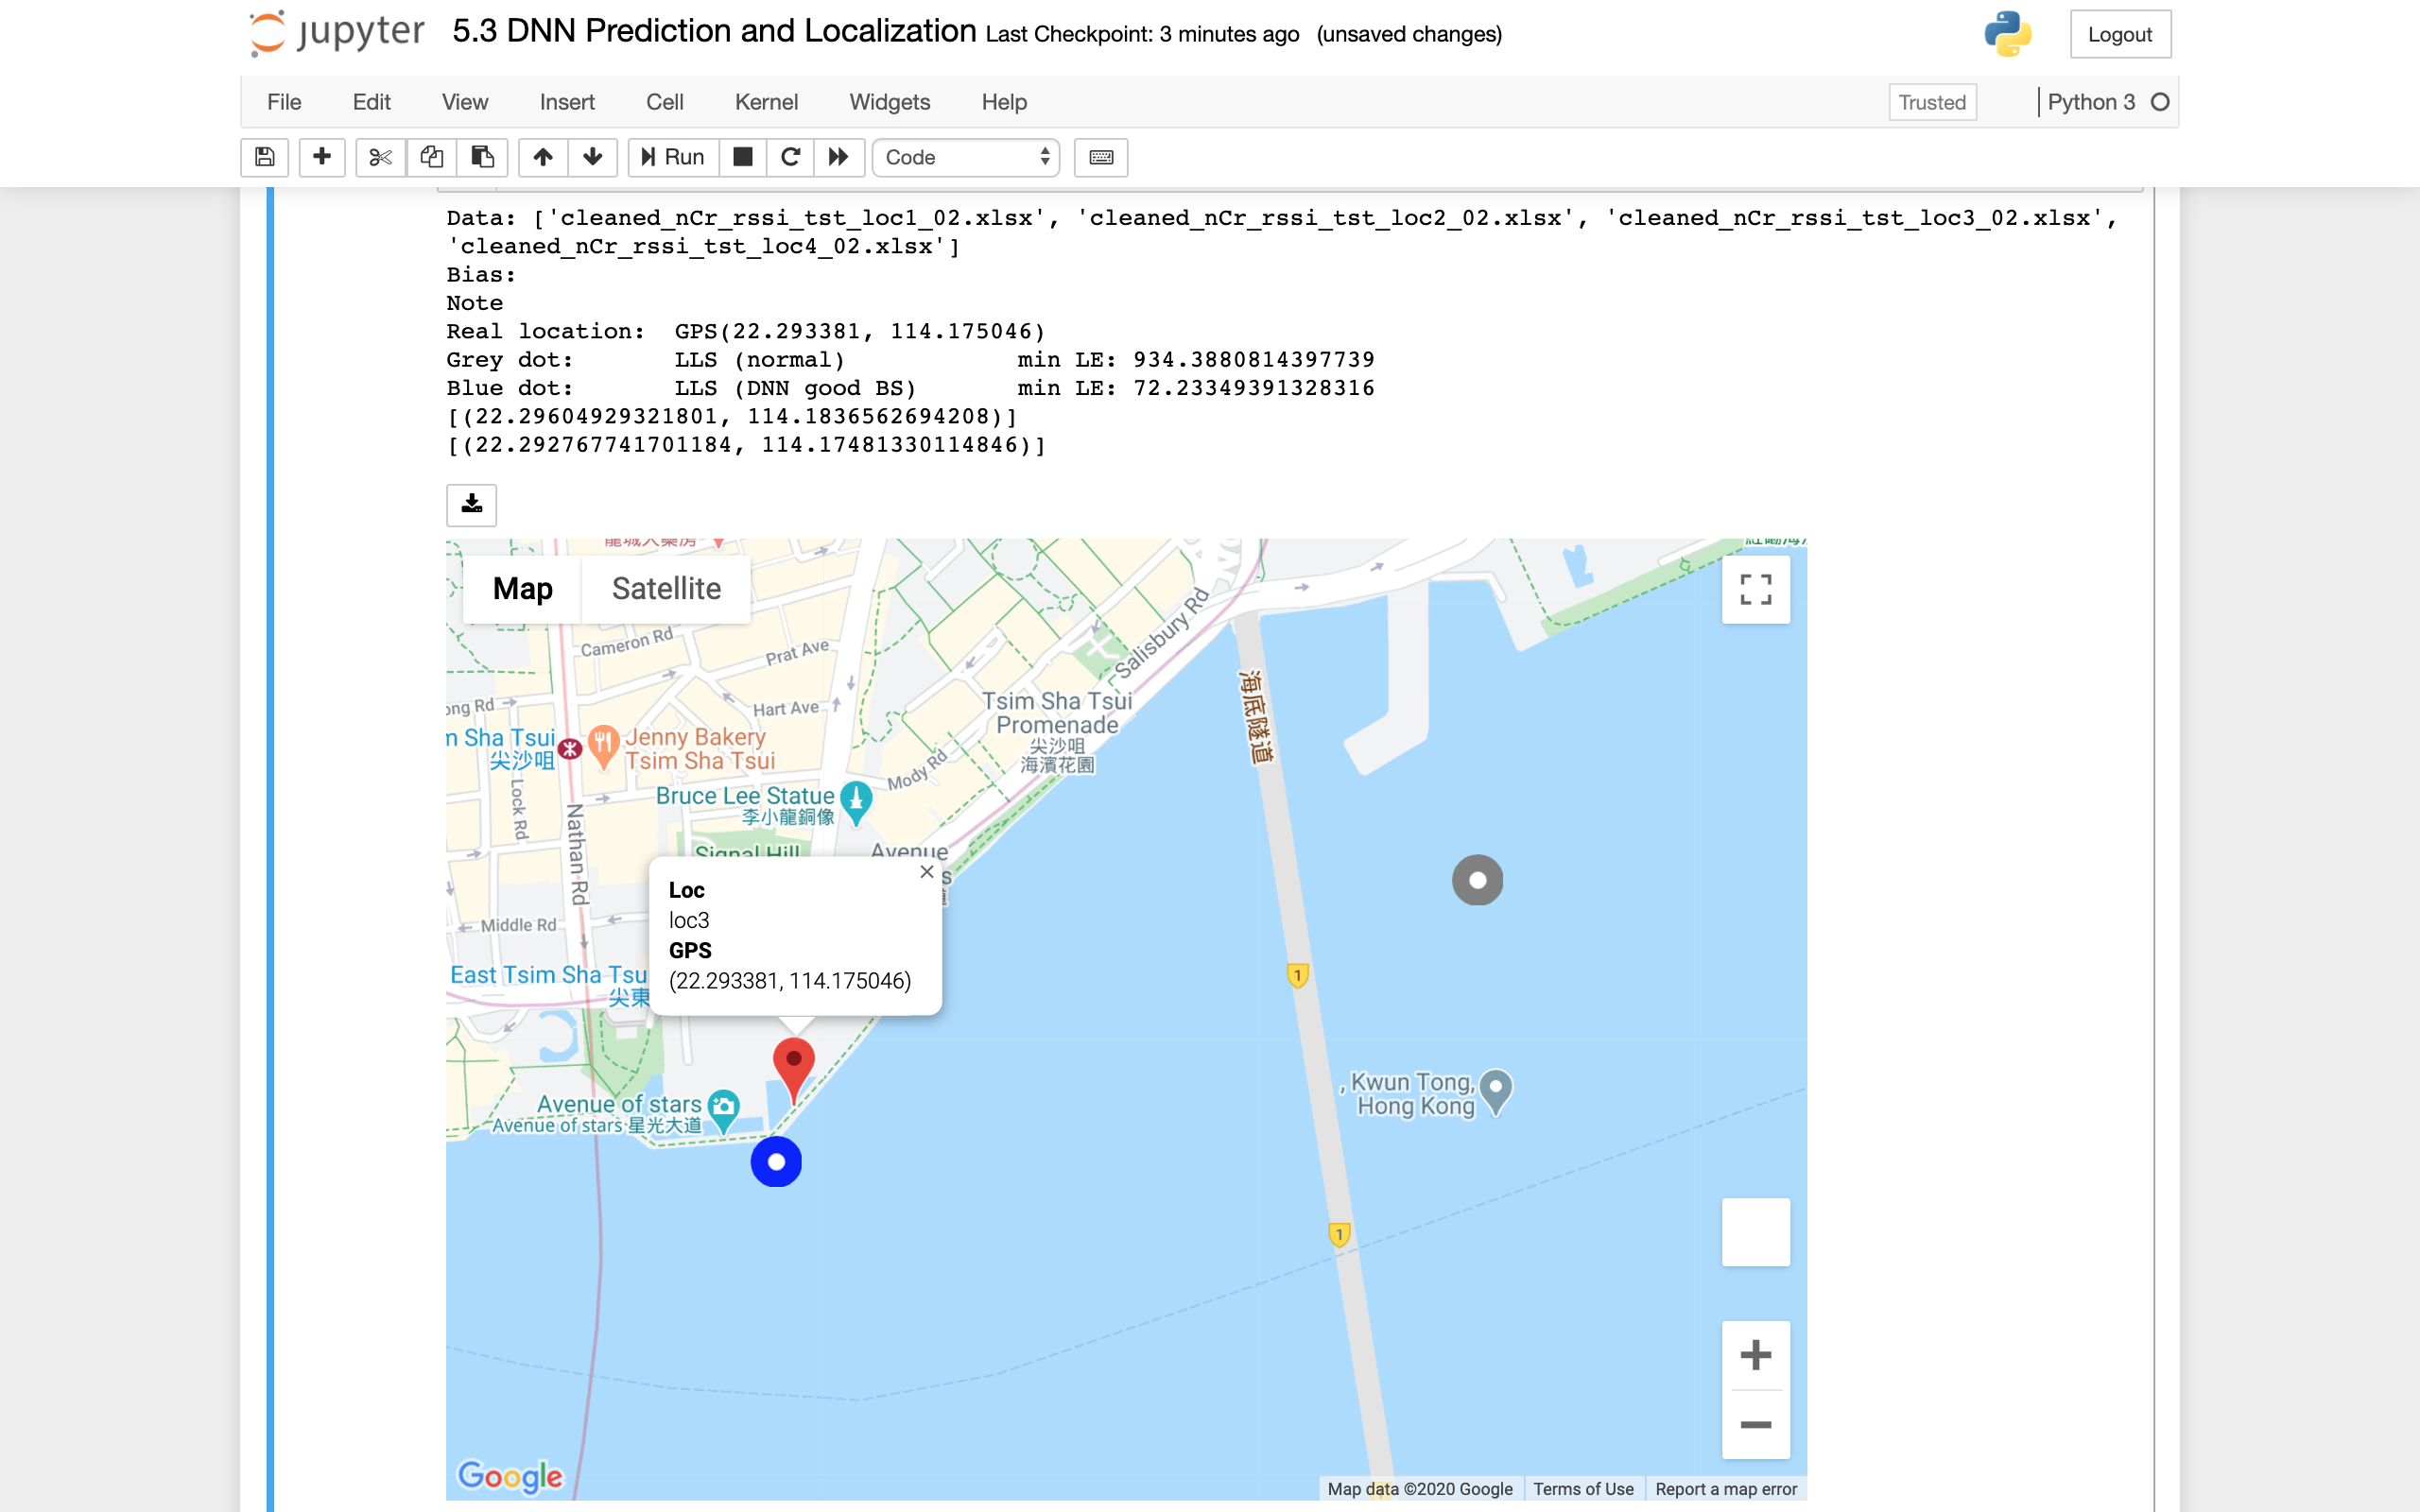

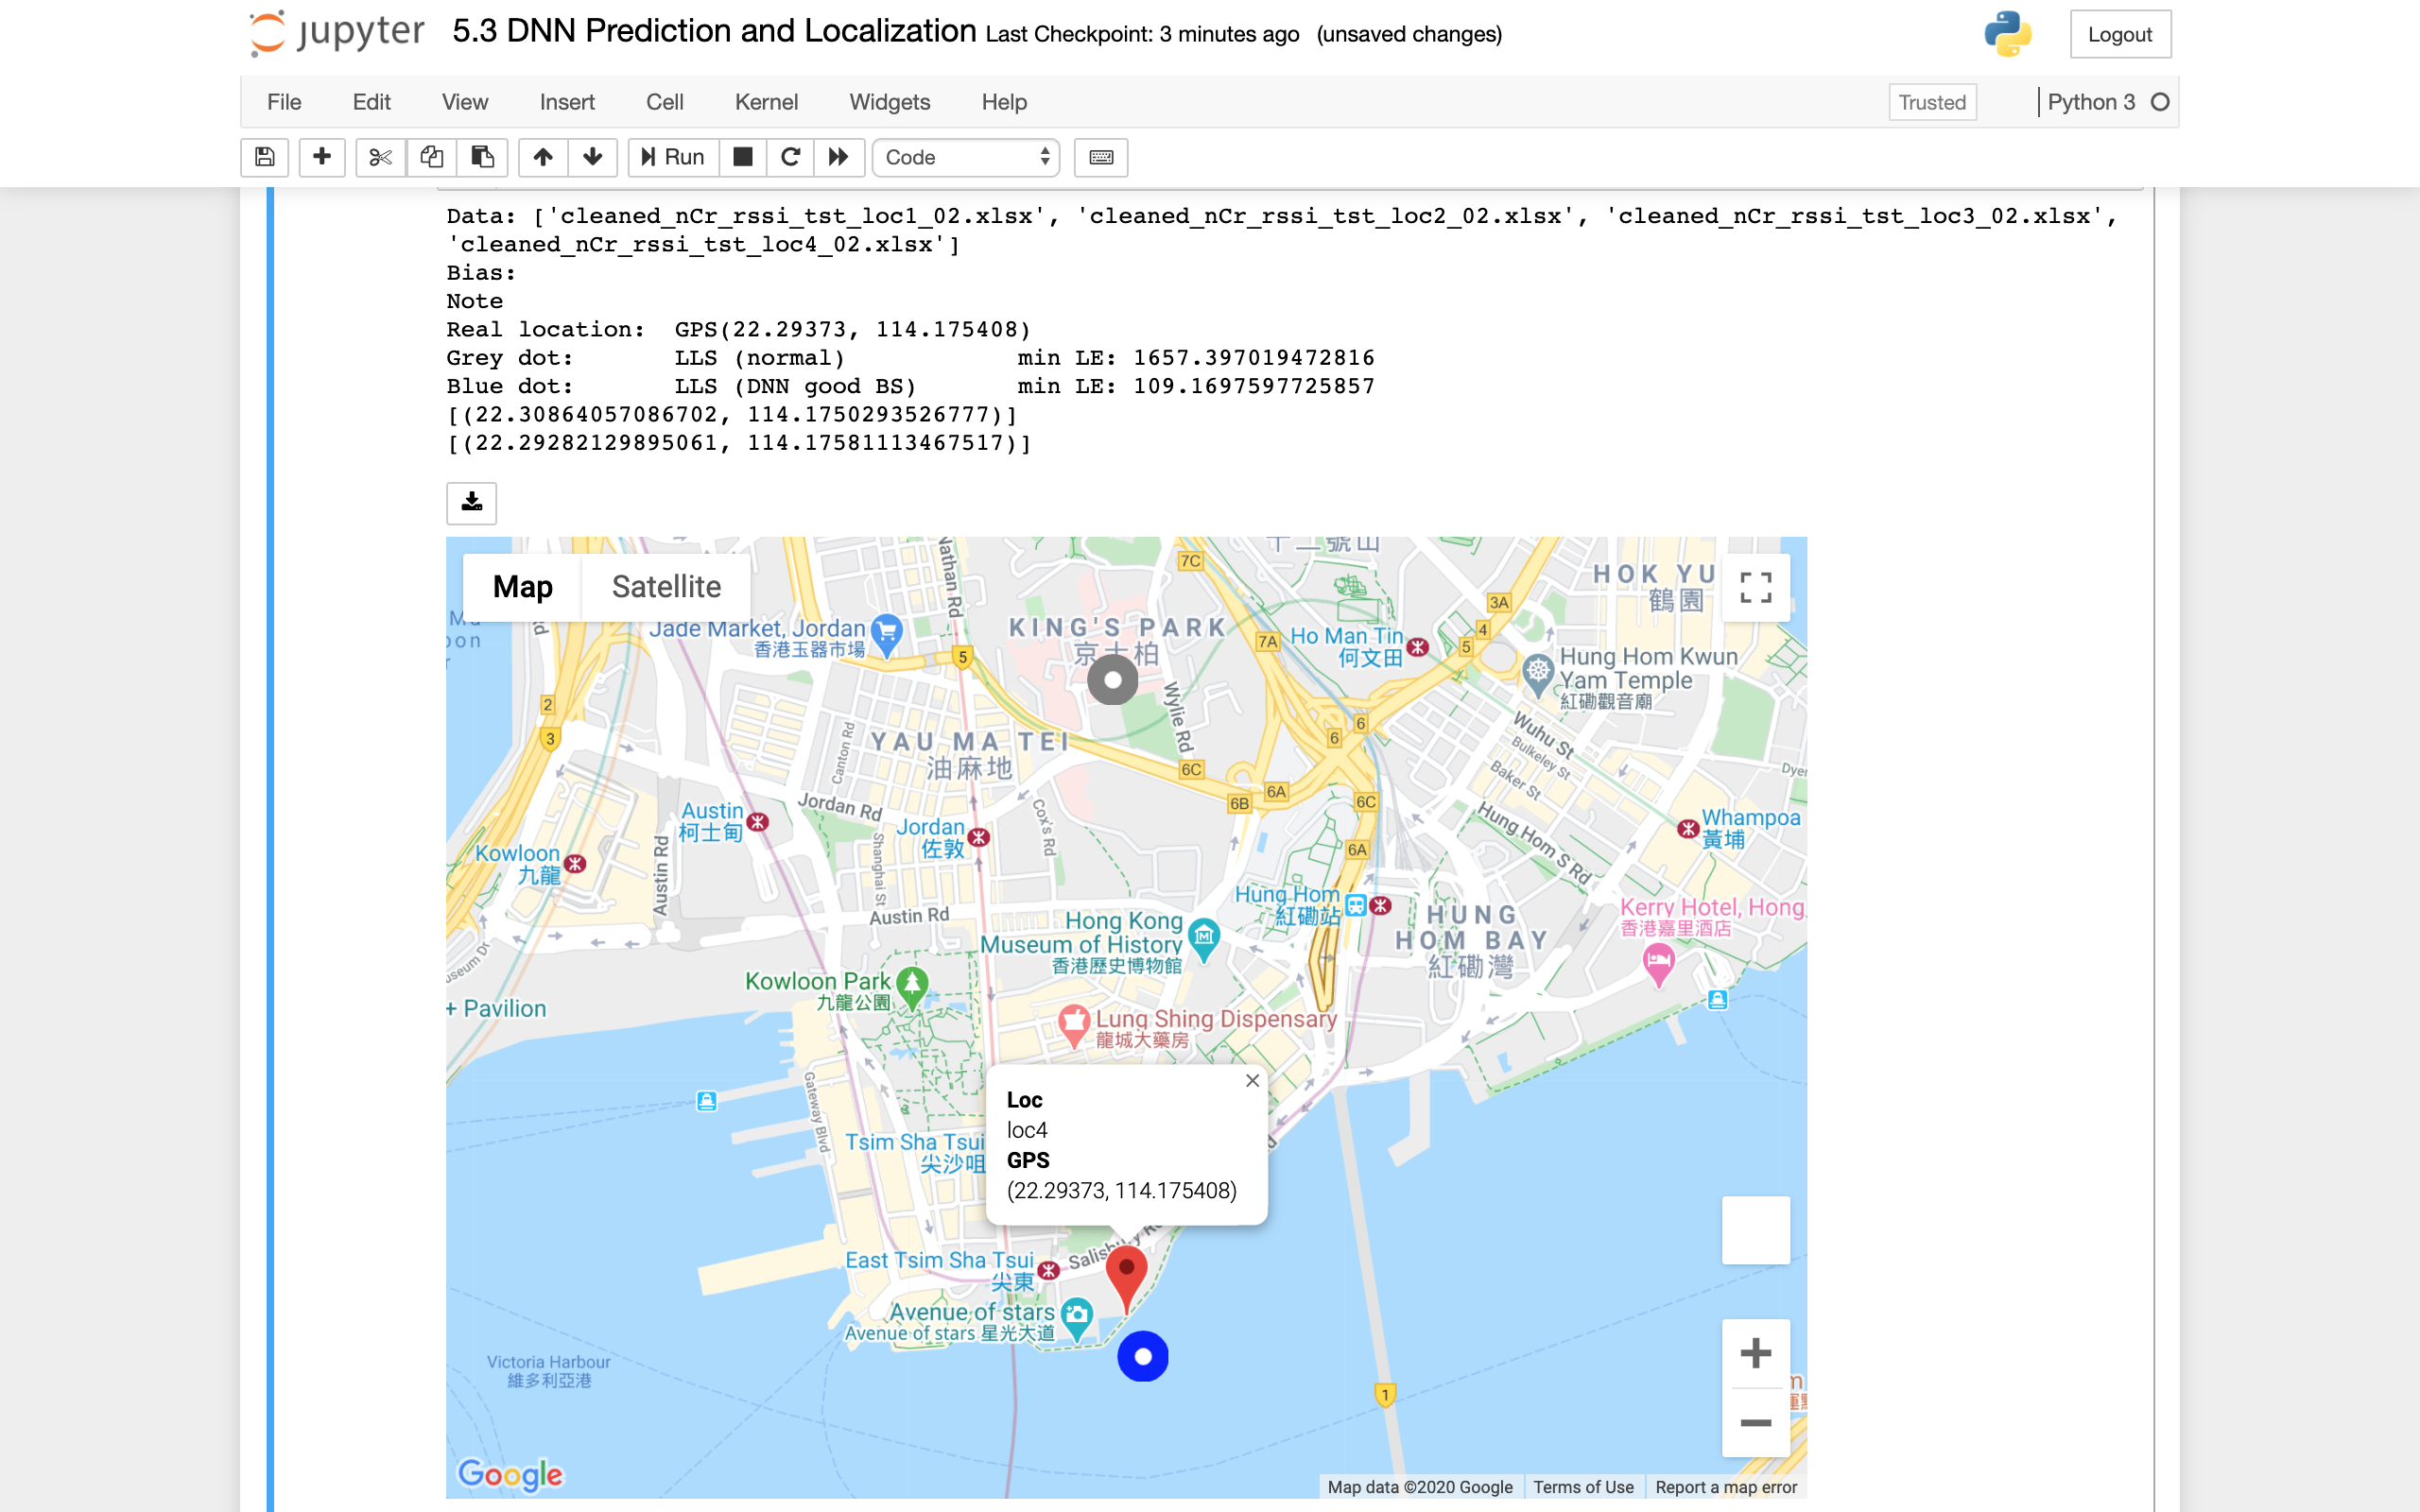

In [27]:
#because I stop my API key, attach an image to show the gmap plot result instead
from IPython.display import Image 
display(Image("img/dnn_lls_loc1_map.png"))
display(Image("img/dnn_lls_loc2_map.png"))
display(Image("img/dnn_lls_loc3_map.png"))
display(Image("img/dnn_lls_loc4_map.png"))

In [28]:
# df_lls_result.to_csv('lls_dnn.csv')